# Introduction

In the [burned-up_area_modelling](./burned-up_area_modelling.ipynb) notebook we have trained a model that classifies the pixel data as burned-up (e.g., after forest fire), using a combination of tasks from `eo-learn`. 

In this notebook, we will construct a typical Earth Observation workflow using [`eo-grow`](https://github.com/sentinel-hub/eo-grow.git), and run it on larger area using the model we have trained before.

The workflow is depicted in the image below:

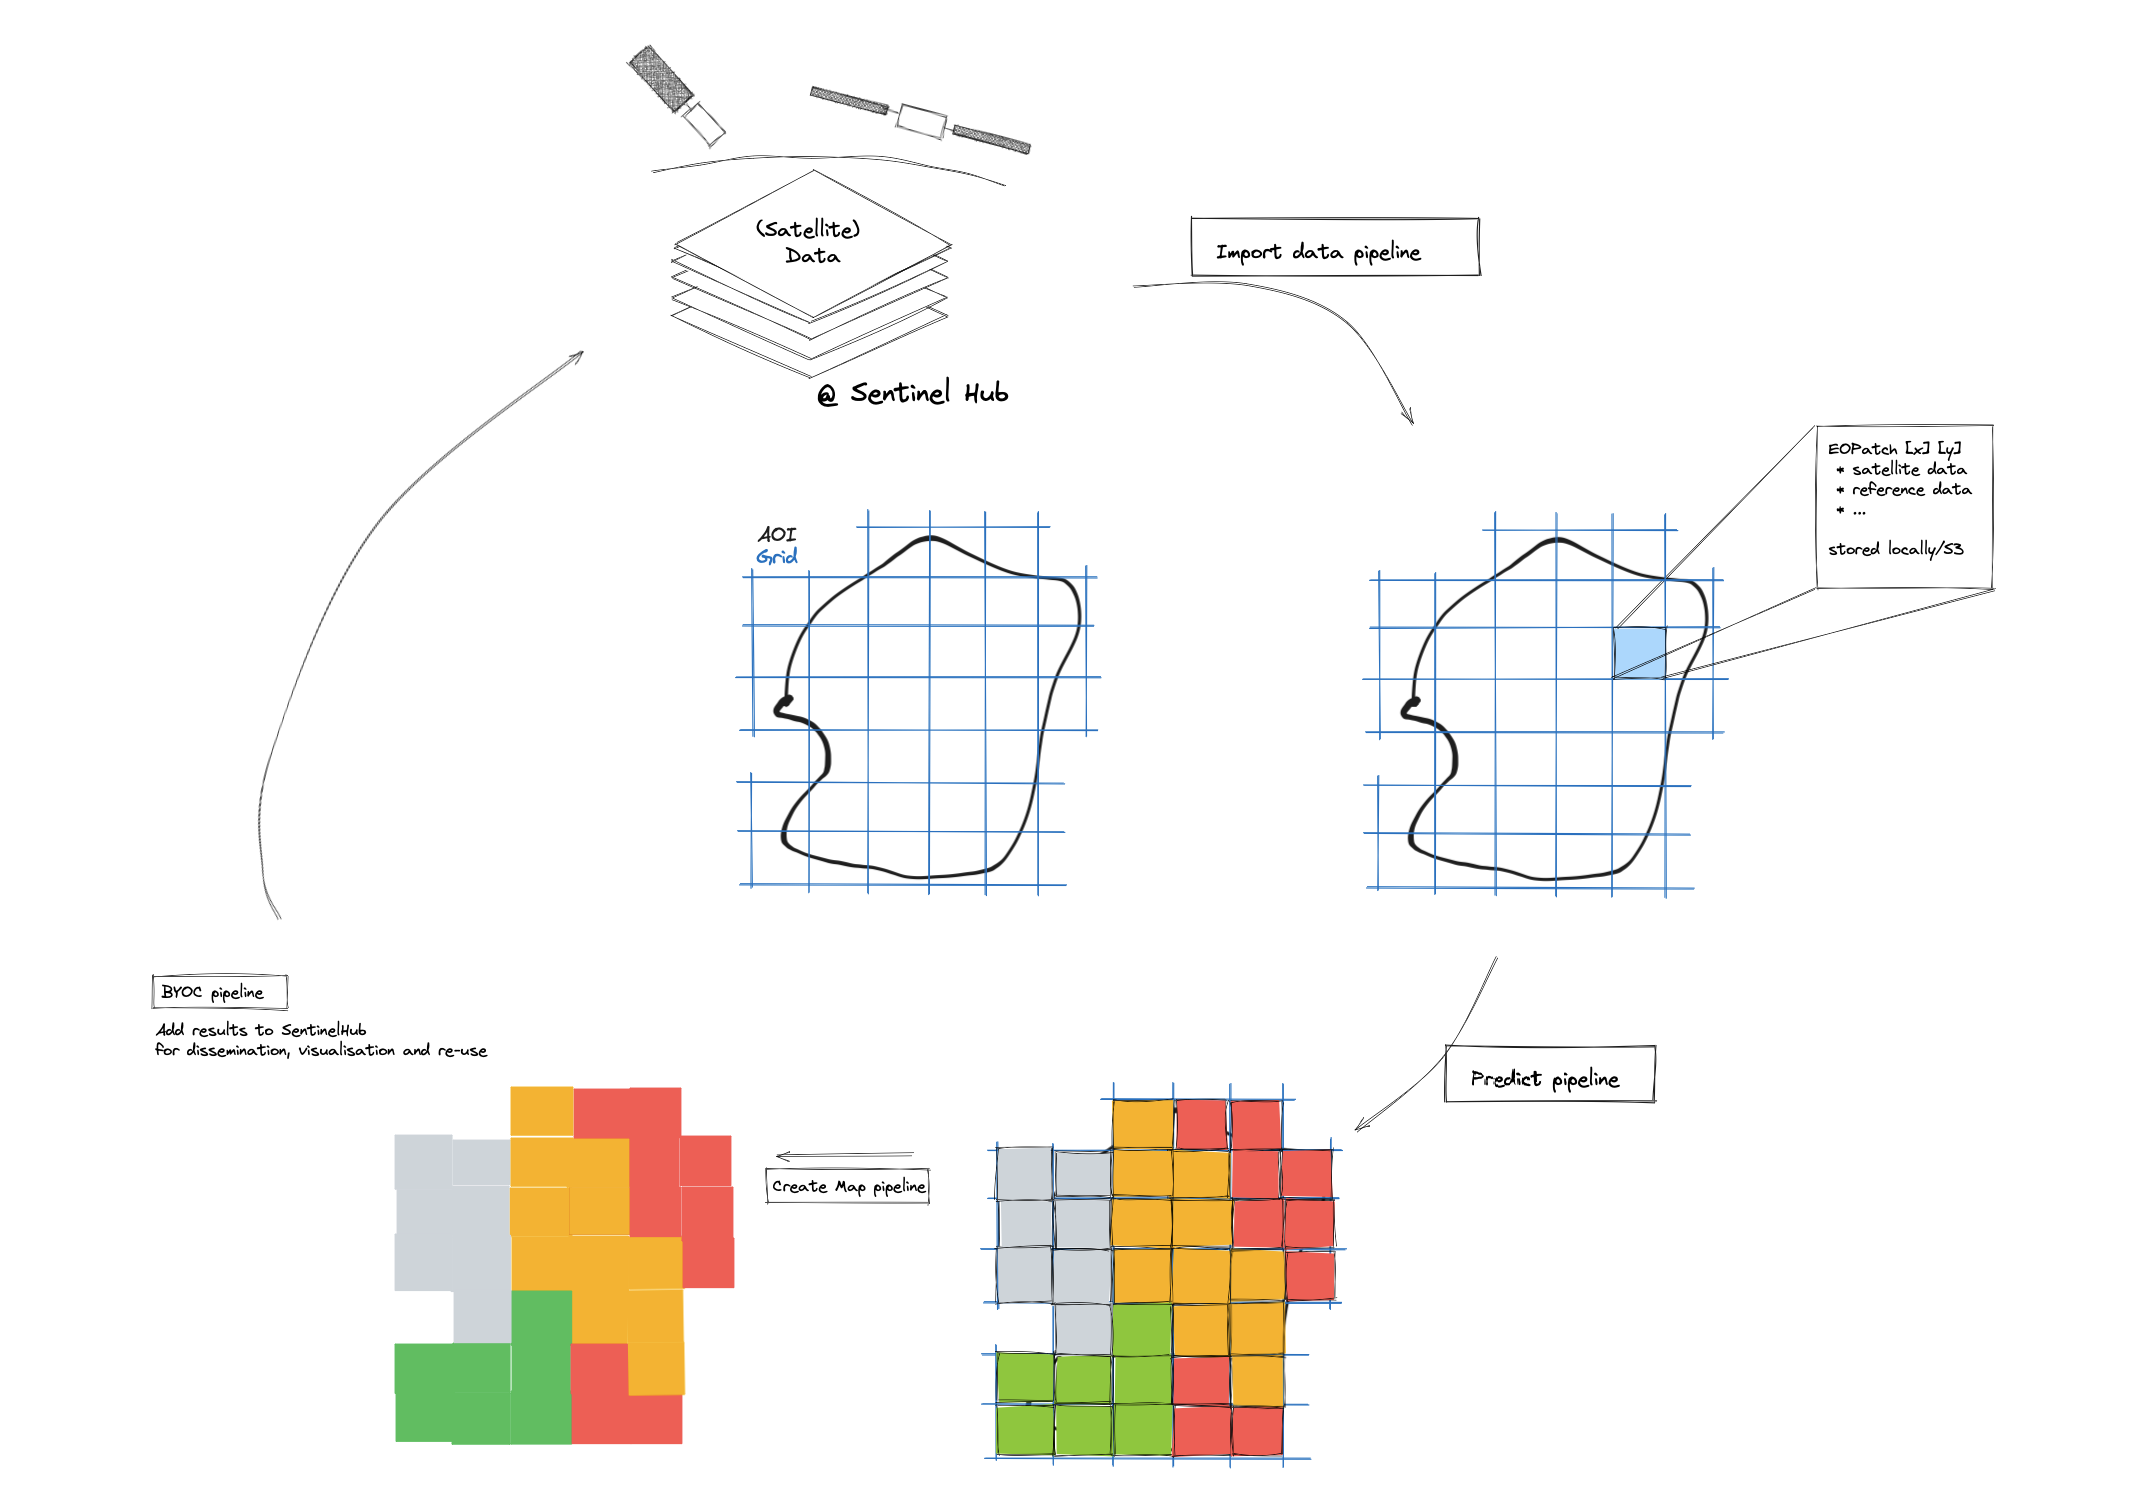

### Installation / upgrade of eo-grow to latest version

If you are running the notebook for the first time, and haven't installed the `eo-grow` package yet, uncomment and run the cell below.

In [1]:
# !pip install eo-grow

### Imports

In [58]:
%matplotlib inline

import os
import warnings
from typing import Any, Dict

import matplotlib.pyplot as plt

from eogrow.core.config import RawConfig, interpret_config_from_dict, recursive_config_join
from eogrow.core.storage import StorageManager
from eogrow.pipelines.download import DownloadEvalscriptPipeline
from eogrow.pipelines.export_maps import ExportMapsPipeline
from eogrow.pipelines.features import FeaturesPipeline
from eogrow.pipelines.prediction import ClassificationPredictionPipeline, ClassificationPredictionTask
from eolearn.core import EOPatch, FeatureType

warnings.filterwarnings("ignore")

### Some helper functions

In [3]:
def prepare_config(global_config: Dict[str, Any], pipeline_config: Dict[str, Any]) -> RawConfig:
    joint_config = recursive_config_join(pipeline_config, global_config)
    return interpret_config_from_dict(joint_config)

## Running the pipelines

### Define area of interest (AOI)

For this example the AOI is covering Karst region in Slovenia, which was affected by a severe fires in summer of 2022.   
The AOI is stored in `demo_aoi.geojson`, and is specified as input parameter in the `AreaManager` part of the global config (below).

### Config with global parameters

The main configuration parameters are defined here: a folder, where everything (data, model, results, ...) will be stored. In this case, the project folder is local path; it could also be a path on object storage (AWS S3). As it is local, one can also copy the notebook and corresponding files under `project` to local machine and run things there.  

In [4]:
PROJECT_FOLDER = os.path.join(os.path.abspath(os.path.curdir), "eogrow_project")

In [5]:
storage_config = {
    "manager": "eogrow.core.storage.StorageManager",
    "project_folder": PROJECT_FOLDER,
    "structure": {
        "data": "data",
        "features": "features",
        "predictions": "predictions",
        "models": "models",
        "maps": "maps",
    },
}

area_config = {
    "manager": "eogrow.core.area.utm.UtmZoneAreaManager",
    "geometry_filename": "area.geojson",
    "patch": {
        "size_x": 10000,
        "size_y": 10000,
    },
}

logging_config = {
    "manager": "eogrow.core.logging.LoggingManager",
    "save_logs": True,
    "show_logs": True,
    "capture_warnings": False,
}

global_config = {"storage": storage_config, "area": area_config, "logging": logging_config}

In [6]:
storage_manager = StorageManager.from_raw_config(storage_config)

### Download pipeline

As for this demonstration we are not using object storage (AWS S3), we will be requesting data through Sentinel Hub ProcessingAPI. When relying on object storage, we could have used the BatchAPI and corresponding `eogrow.pipelines.batch_download.BatchDownloadPipeline`.

This pipeline takes care of the first step in literally any EO workflow: getting the data.

In [16]:
download_config = {
    "pipeline": "eogrow.pipelines.download.DownloadEvalscriptPipeline",
    "data_collection": "SENTINEL2_L2A",
    "time_period": ["2022-07-01", "2022-08-01"],
    "resolution": 120,
    "skip_existing": True,
    "output_folder_key": "data",
    "features": [["data", "BANDS"], ["mask", "dataMask"]],
    "postprocessing": {
        "rescale_schemas": [
            {
                "rescale_factor": 0.0001,
                "dtype": "float",
                "features_to_rescale": [["data", "BANDS"]],
            }
        ],
    },
    "evalscript_path": "evalscript.js",
}

In [17]:
download_pipeline = DownloadEvalscriptPipeline.from_raw_config(prepare_config(global_config, download_config))

In [18]:
download_pipeline.run()

 INFO [16:02:36] eogrow.core.pipeline:232: Running DownloadEvalscriptPipeline
 INFO [16:02:36] eogrow.core.area.base:102: Loading grid from cache/UtmZoneAreaManager_area_10000_10000_0.0_0.0_0.0_0.0.gpkg
 INFO [16:02:36] eogrow.core.pipeline:117: Checking which EOPatches can be skipped


Checking EOPatches:   0%|          | 0/3 [00:00<?, ?it/s]

 INFO [16:02:36] eogrow.core.pipeline:123: No EOPatches were skipped, 3 / 3 remaining


2024-04-11 16:02:36,885	INFO worker.py:1431 -- Connecting to existing Ray cluster at address: 127.0.0.1:65507...
2024-04-11 16:02:36,885	INFO worker.py:1453 -- Calling ray.init() again after it has already been called.


 INFO [16:02:36] eogrow.core.pipeline:178: Starting processing for 3 EOPatches


  0%|          | 0/3 [00:00<?, ?it/s]

 INFO [16:02:39] eogrow.core.pipeline:202: RayExecutor finished with 3 / 3 success rate
 INFO [16:02:39] eogrow.core.pipeline:211: Saved EOExecution report to /Users/batic/Work/git/eo/core/eo-learn-examples/AgriDataValue/Burned-up_area/eogrow_project/logs/2024-04-11T14-02-36Z-DownloadEvalscriptPipeline-870f95b062/eoexecution-report-2024_04_11-16_02_36/report.html
 INFO [16:02:39] eogrow.core.pipeline:241: Pipeline finished successfully!


### Features pipeline

In this pipeline we are computing a (trivial) set of indices. With SentinelHub we could have easily retrieved them via apropriately tailored evalscript, reducing also the amout of requested data. 

At the `FeaturesPipeline` is meant to prepare features for the model, it will append the normalised density indices to the existing bands.

In [19]:
features_config = {
    "pipeline": "eogrow.pipelines.features.FeaturesPipeline",
    "input_folder_key": "data",
    "output_folder_key": "features",
    "bands_feature_name": "BANDS",
    "data_preparation": {
        "valid_data_feature_name": "dataMask"  # because we won't do any filtering this feature plays no role
    },
    "output_feature_name": "FEATURES",
    "dtype": "float",
    "skip_existing": True,
}

In [20]:
features_pipeline = FeaturesPipeline.from_raw_config(prepare_config(global_config, features_config))

In [21]:
features_pipeline.run()

 INFO [16:05:31] eogrow.core.pipeline:232: Running FeaturesPipeline
 INFO [16:05:31] eogrow.core.area.base:102: Loading grid from cache/UtmZoneAreaManager_area_10000_10000_0.0_0.0_0.0_0.0.gpkg
 INFO [16:05:31] eogrow.core.pipeline:117: Checking which EOPatches can be skipped


Checking EOPatches:   0%|          | 0/3 [00:00<?, ?it/s]

 INFO [16:05:31] eogrow.core.pipeline:123: No EOPatches were skipped, 3 / 3 remaining


2024-04-11 16:05:32,124	INFO worker.py:1431 -- Connecting to existing Ray cluster at address: 127.0.0.1:65507...
2024-04-11 16:05:32,127	INFO worker.py:1453 -- Calling ray.init() again after it has already been called.


 INFO [16:05:32] eogrow.core.pipeline:178: Starting processing for 3 EOPatches


  0%|          | 0/3 [00:00<?, ?it/s]

 INFO [16:05:32] eogrow.core.pipeline:202: RayExecutor finished with 3 / 3 success rate
 INFO [16:05:32] eogrow.core.pipeline:211: Saved EOExecution report to /Users/batic/Work/git/eo/core/eo-learn-examples/AgriDataValue/Burned-up_area/eogrow_project/logs/2024-04-11T14-05-31Z-FeaturesPipeline-0edeea410b/eoexecution-report-2024_04_11-16_05_32/report.html
 INFO [16:05:32] eogrow.core.pipeline:241: Pipeline finished successfully!


### Prediction pipeline - WIP

As specified, this workflow is a slimmed down version of the full example, available on `eo-grow-examples`. As such, we are skipping the training part, and will continue straight with the prediction pipeline, using the model that is the result from the full example. For ease of use, the model is included in this example at `eogrow_project/models/`.

In [54]:
from typing import Any, Callable

import fs
import numpy as np

from eolearn.core import EONode

In [78]:
class PerTimestampPredictionPipeline(ClassificationPredictionPipeline):
    config: ClassificationPredictionPipeline.Schema

    def _get_prediction_node(self, previous_node: EONode) -> EONode:
        model_path = fs.path.join(self.storage.get_folder(self.config.model_folder_key), self.config.model_filename)
        prediction_task = PredictionTask(
            model_path=model_path,
            filesystem=self.storage.filesystem,
            input_features=self.config.input_features,
            output_feature=(FeatureType.MASK, self.config.output_feature_name),
            output_probability_feature=(FeatureType.DATA, self.config.output_probability_feature_name),
            output_dtype=self.config.dtype,
            label_encoder_filename=None,
            mask_feature=None,
        )
        return EONode(prediction_task, inputs=[previous_node])


class PredictionTask(ClassificationPredictionTask):
    def apply_predictor(
        self, predictor: Callable, processed_features: np.ndarray, return_on_empty: np.ndarray | None = None
    ) -> np.ndarray:
        print(f"{processed_features.shape=}")
        predictions = []
        for feat in processed_features:
            predictions.append(predictor(feat))

        return np.array(predictions).astype(self.output_dtype) if self.output_dtype else np.array(predictions)

In [79]:
prediction_config = {
    "pipeline": "PerTimestampPredictionPipeline",
    "input_folder_key": "features",
    "model_folder_key": "models",
    "output_folder_key": "predictions",
    "input_features": [["data", "FEATURES"]],
    "output_feature_name": "prediction",
    "output_probability_feature_name": "probabilities",
    "dtype": "float32",
    "model_filename": "wildfires_model.pkl",
    "skip_existing": True,
}

In [80]:
prediction_pipeline = PerTimestampPredictionPipeline.from_raw_config(prepare_config(global_config, prediction_config))

In [81]:
prediction_pipeline.run()

 INFO [16:44:29] eogrow.core.pipeline:232: Running PerTimestampPredictionPipeline
 INFO [16:44:29] eogrow.core.area.base:102: Loading grid from cache/UtmZoneAreaManager_area_10000_10000_0.0_0.0_0.0_0.0.gpkg
 INFO [16:44:29] eogrow.core.pipeline:117: Checking which EOPatches can be skipped


Checking EOPatches:   0%|          | 0/3 [00:00<?, ?it/s]

 INFO [16:44:29] eogrow.core.pipeline:123: No EOPatches were skipped, 3 / 3 remaining


2024-04-11 16:44:29,331	INFO worker.py:1431 -- Connecting to existing Ray cluster at address: 127.0.0.1:65507...
2024-04-11 16:44:29,332	INFO worker.py:1453 -- Calling ray.init() again after it has already been called.


 INFO [16:44:29] eogrow.core.pipeline:178: Starting processing for 3 EOPatches


  0%|          | 0/3 [00:00<?, ?it/s]

 INFO [16:44:29] eogrow.core.pipeline:202: RayExecutor finished with 0 / 3 success rate
(_ray_workflow_executor pid=83973) processed_features.shape=(6889, 312)
 INFO [16:44:29] eogrow.core.pipeline:211: Saved EOExecution report to /Users/batic/Work/git/eo/core/eo-learn-examples/AgriDataValue/Burned-up_area/eogrow_project/logs/2024-04-11T14-44-29Z-PerTimestampPredictionPipeline-6561a5723b/eoexecution-report-2024_04_11-16_44_29/report.html
 INFO [16:44:29] eogrow.core.pipeline:239: Pipeline finished with some errors! Check /Users/batic/Work/git/eo/core/eo-learn-examples/AgriDataValue/Burned-up_area/eogrow_project/logs/2024-04-11T14-44-29Z-PerTimestampPredictionPipeline-6561a5723b


PipelineExecutionError: Pipeline failed some executions. Check /Users/batic/Work/git/eo/core/eo-learn-examples/AgriDataValue/Burned-up_area/eogrow_project/logs/2024-04-11T14-44-29Z-PerTimestampPredictionPipeline-6561a5723b.

This pipeline takes care of exporting final results as cloud-optimised-geotiffs (see parameter `cofigy=True` in config below). 

<img src="docs/figs/maps_pipeline.png" width="500 px" />

In [31]:
export_map_config = {
    "pipeline": "eogrow.pipelines.export_maps.ExportMapsPipeline",
    "input_folder_key": "predictions",
    "output_folder_key": "maps",
    "feature": ["data_timeless", "test_prediction"],
    "map_name": "result.tiff",
    "map_dtype": "uint8",
    "band_indices": [0],
    "cogify": True,
    "workers": 1,
}

In [32]:
export_pipeline = ExportMapsPipeline.from_raw_config(prepare_config(global_config, export_map_config))

In [33]:
export_pipeline.run()

INFO eogrow.core.pipeline:225: Running ExportMapsPipeline
INFO eogrow.core.area.base:108: Loading grid from cache/UtmZoneAreaManager_demo-aoi_30720_30720_0.0_0.0_0.0_0.0.gpkg
INFO eogrow.core.pipeline:175: Starting EOExecutor for 6 EOPatches


  0%|          | 0/6 [00:00<?, ?it/s]

INFO eogrow.core.pipeline:197: EOExecutor finished with 6 / 6 success rate
INFO eogrow.core.pipeline:206: Saved EOExecution report to /Users/batic/Work/git/eo/core/eo-grow-examples/GEM/project/logs/2023-02-14T13-10-36Z-ExportMapsPipeline-c5ed7301f3/eoexecution-report-2023_02_14-14_10_36/report.html
INFO eogrow.pipelines.export_maps:133: Processing CRS 32631
INFO eogrow.pipelines.export_maps:156: Merging TIFF files.


  0%|          | 0/1 [00:00<?, ?it/s]

INFO eogrow.pipelines.export_maps:163: Finalizing output.


  0%|          | 0/1 [00:00<?, ?it/s]

INFO eogrow.pipelines.export_maps:327: Merged maps are saved in /Users/batic/Work/git/eo/core/eo-grow-examples/GEM/project/maps/UTM_32631
INFO eogrow.core.pipeline:237: Pipeline finished successfully!


### Ingest results to BYOD on Sentinel Hub

The following code would ingest the results back to the Sentinel Hub services (using [Bring Your Own Data](https://docs.sentinel-hub.com/api/latest/api/byoc/)) if we were using object storage (AWS S3 bucket) for project's storage.

<img src="docs/figs/byoc_pipeline.png" width="700 px"/>


```python
ingestion_config = {
  "pipeline": "eogrow.pipelines.byoc.IngestByocTilesPipeline",
  "byoc_tile_folder_key": "maps",
  "new_collection_name": "GEM eo-grow example predictions over Lagos",
  "sensing_time": "2020-12-31",
  "cover_geometry_folder_key": "input_data",
  "cover_geometry": "demo-aoi.geojson"
}

ingestion_pipeline = IngestByocTilesPipeline.from_raw_config(prepare_config(global_config, ingestion_config))
ingestion_pipeline.run()
```

### Visualize the results

As we cannot use BYOC functinality in this (non object storage based) example, we'll rely on eo-learn and matplotlib to quickly visualize the results of built-up areas in the AOI. 

In [34]:
from tqdm.auto import tqdm as tqdm

In [35]:
%matplotlib inline

  0%|          | 0/6 [00:00<?, ?it/s]

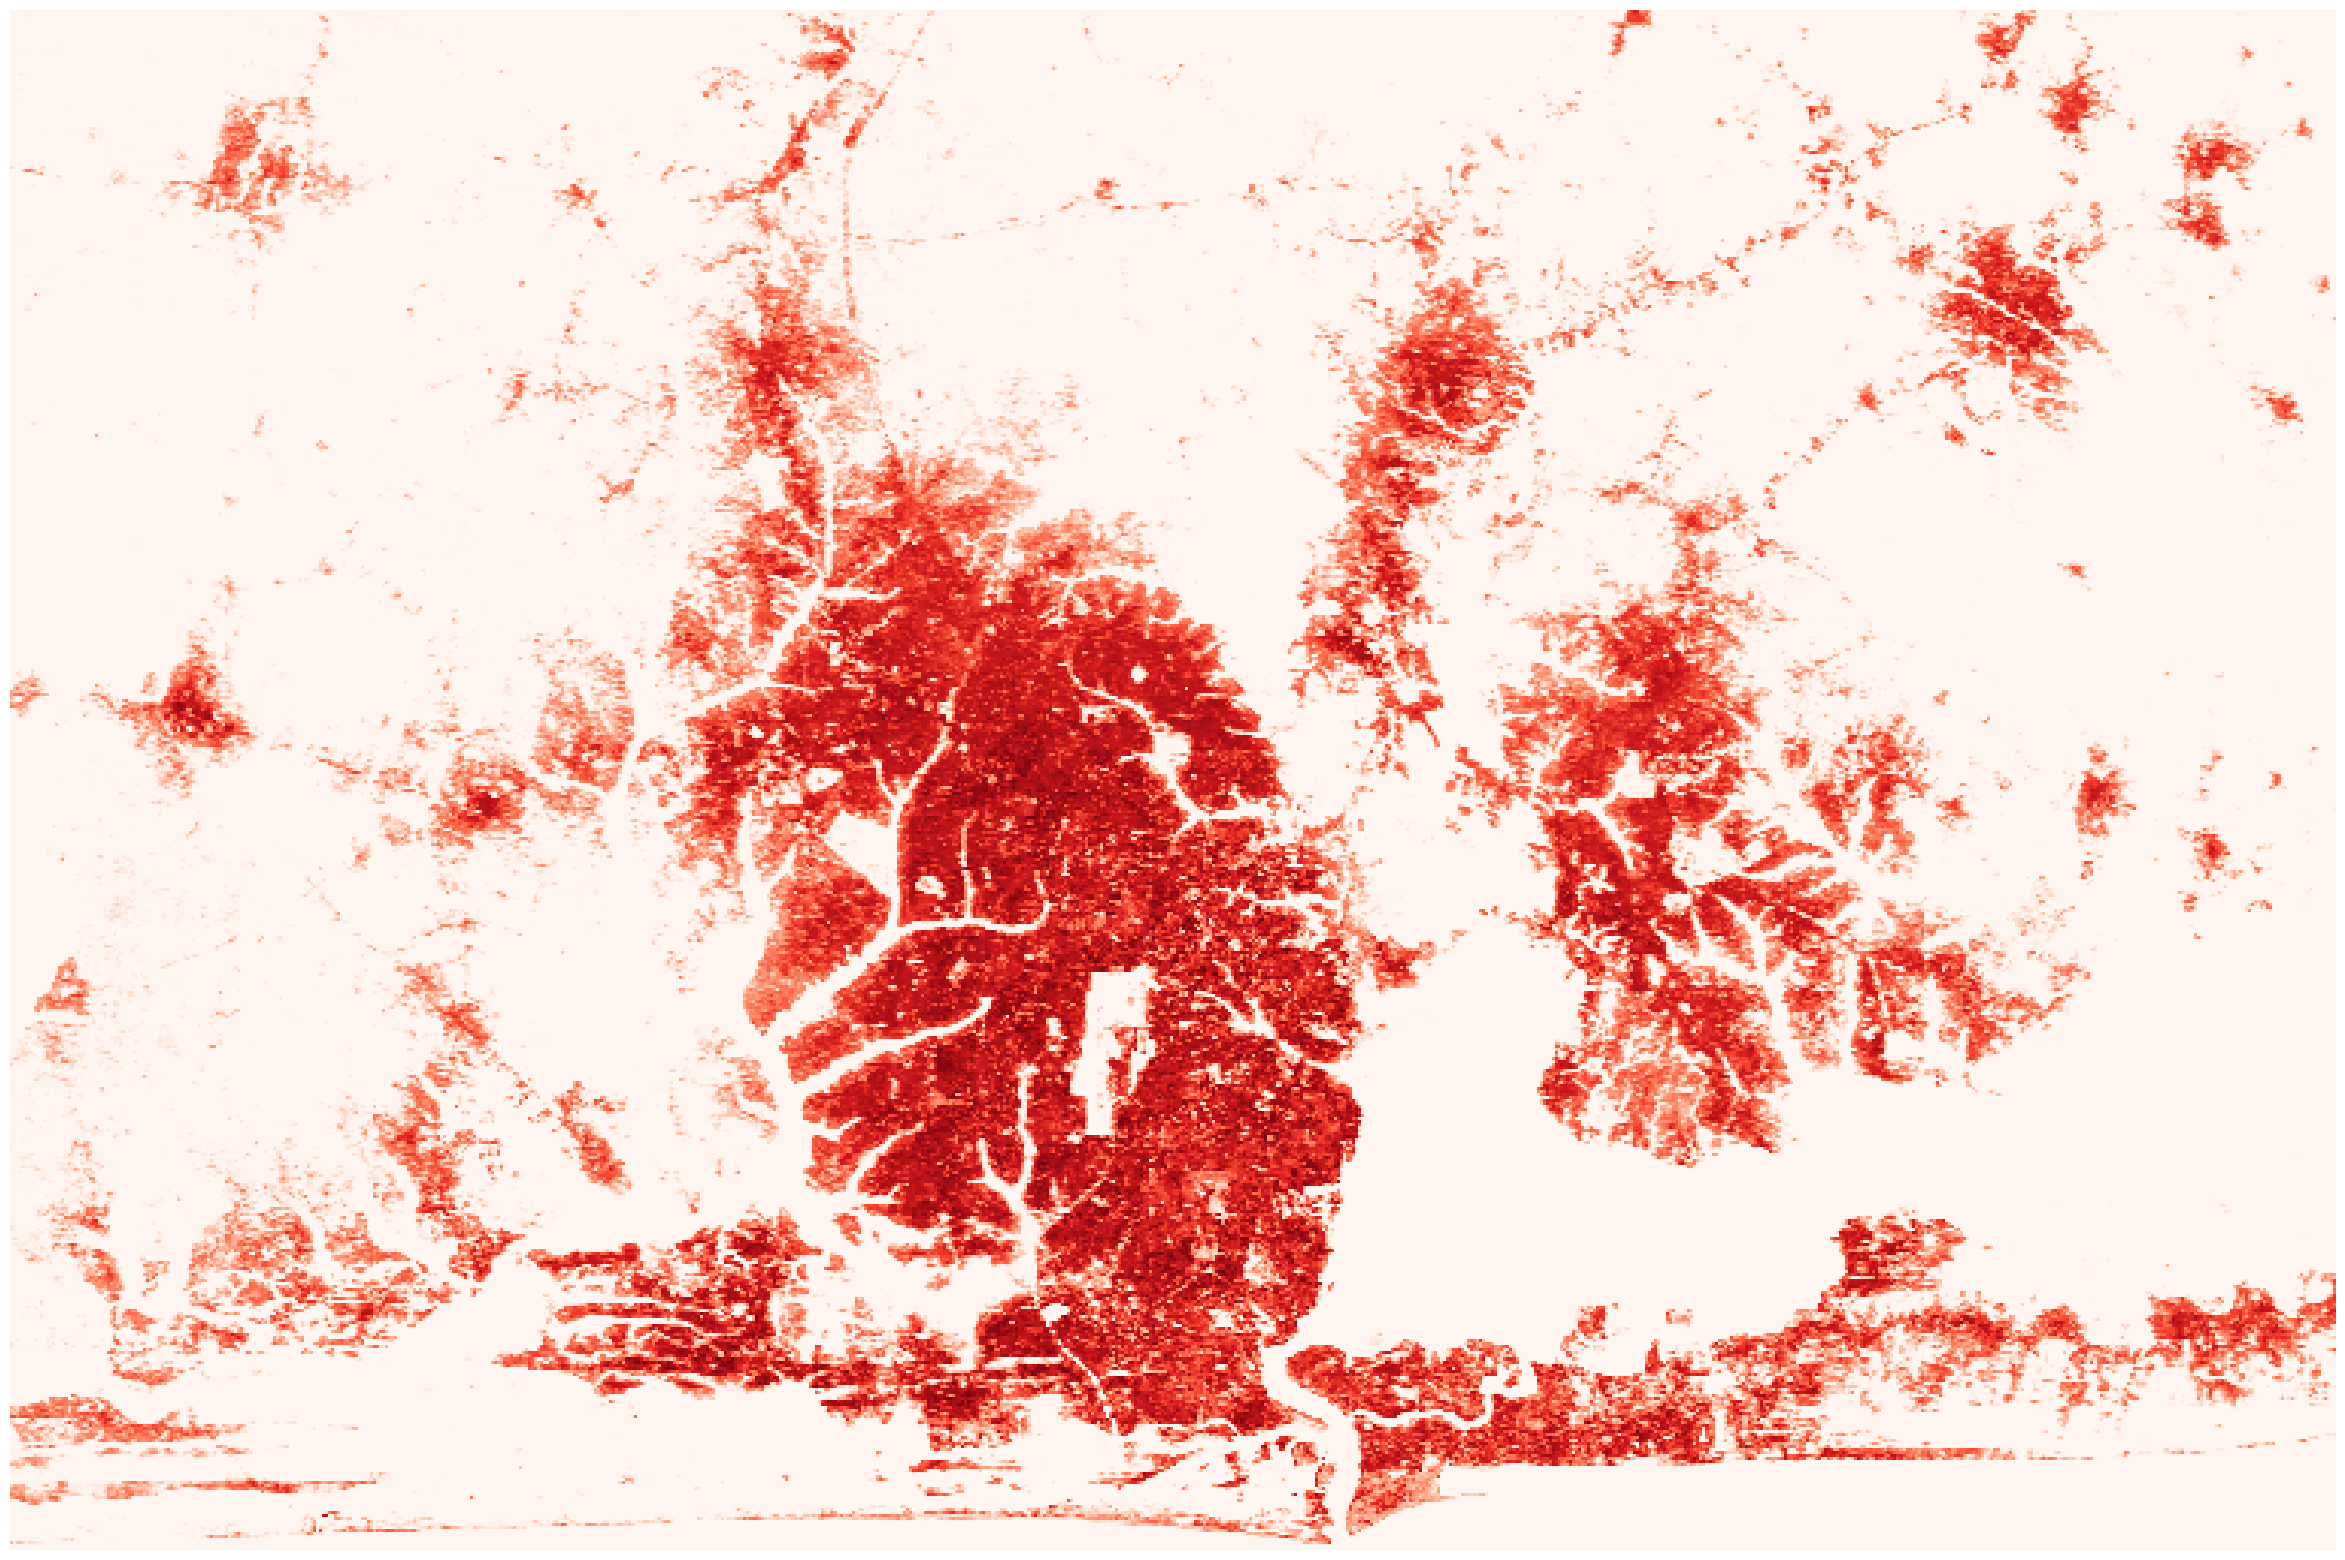

In [36]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(30, 20))

for eop_name, _ in tqdm(download_pipeline.area_manager.get_patch_list()):
    eopatch_path = os.path.join(storage_manager.get_folder("predictions", full_path=True), eop_name)
    eopatch = EOPatch.load(eopatch_path, lazy_loading=True)

    j, i = int(eop_name.split("-")[4]), int(eop_name.split("-")[6])
    ax = axs[1 - i][j]
    ax.imshow(eopatch.data_timeless["test_prediction"].squeeze(), vmin=5, vmax=80, cmap="Reds")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    ax.set_axis_off()
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)